# Model proto

This is a rough prototype of our RL solution

In [232]:
import os
if os.getcwd() == '/kaggle/working':
    import sys
    
    !rm -rf 'PMLDL-Project'
    !git clone -b main https://github.com/Sambura/PMLDL-Project
    
    if 'PMLDL-Project' not in sys.path: sys.path.append('PMLDL-Project')

In [233]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.agent.agent_pg import DnDAgentPolicyGradient
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop
from src.agent.training import *
from src.dnd.game_configs import *

In [235]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [236]:
def train_loop_sequential_V1_PG(agent: DnDAgentPolicyGradient, 
                                game: DnDBoard,
                                reward_fn: callable,
                                iter_limit: int=10000,
                                raise_on_limit: bool=False) -> int:
    if not agent.sequential_actions:
        raise RuntimeWarning('Provided agent is incompatible with this train loop')

    player_memory = [([], [], []) for _ in game.players_to_units]
    for iter_count in range(iter_limit):
        unit, player_id = game.current_unit, game.current_player_id

        while game.current_unit.is_alive() and game.current_movement_left > 0 or not game.used_action: # while unit is still able to do something
            state, action_vector, new_coords, action = get_states_seq(game, agent)
            if np.sum(agent.last_mask) <= 1: break
            action_legal, move_legal = None, None

            if new_coords is not None: # move to new_coords
                move_legal, updates = game.move(new_coords, raise_on_illegal=False)
                finish_turn = not move_legal
            elif action is not None: # invoke the action
                action_legal, updates = game.use_action(action, raise_on_illegal=False)
                finish_turn = not action_legal
            else:
                finish_turn = True
                updates = None

            game_state = game.get_game_state(player_id)
            reward = reward_fn(game, game_state, unit, player_id, move_legal, action_legal, updates)
            player_memory[player_id][0].append(state)
            player_memory[player_id][1].append(action_vector)
            player_memory[player_id][2].append(reward)

            if game_state != GameState.PLAYING:
                #player_memory[1 - player_id][2][-1] = -reward
                for memory in player_memory: agent.memorize_episode(*memory)
                return iter_count + 1, len(player_memory[0][2]) + len(player_memory[1][2])

            if finish_turn: break

        game.finish_turn()
    
    if raise_on_limit: raise RuntimeError('Iteration limit exceeded')

    # for memory in player_memory: agent.memorize_episode(*memory)

    return iter_limit, 0 #len(player_memory[0][2]) + len(player_memory[1][2])

In [237]:
def calculate_reward_classic_seq_PG(game, game_state, unit: Unit, player_id: int, move_legal: bool, action_legal: bool, updates: dict):
    # if move_legal is None and action_legal is None: return -0.001

    if len(game.players_to_units[player_id]) == 0:
        return -1
    
    if len(game.players_to_units[player_id]) == len(game.units):
        return 1
    
    return 0

In [238]:
board_size, game_config = get_2v2_1_config()

In [239]:
yi, xi = np.meshgrid(np.arange(board_size[0]), np.arange(board_size[1]), indexing='ij')

def dnd_legal_moves_masker(state, ch_out):
    remaining_speed = state[11, 0, 0]
    can_move = remaining_speed > 0
    can_act = state[12, 0, 0] > 0

    mask = np.zeros((ch_out, *state.shape[1:]))
    if can_move or can_act:
        current_unit_pos = np.where(state[2] != 0)
        y, x = current_unit_pos[0][0], current_unit_pos[1][0]        
        distance = np.abs(yi - y) + np.abs(xi - x)

        if can_move:
            occupied = np.logical_or(state[0], state[1])
            possible_positions = np.where(np.logical_and(distance <= remaining_speed, occupied == 0))
            mask[0, possible_positions[0], possible_positions[1]] = 1
        if can_act:
            attack_range = state[4, y, x]
            possible_targets = np.where(np.logical_and(state[1], distance <= attack_range))
            mask[1, possible_targets[0], possible_targets[1]] = 1

    mask[2, 0, 0] = 1

    return mask

In [240]:
agent = DnDAgentPolicyGradient(board_shape=board_size, in_channels=DnDBoard.STATE_CHANNEL_COUNT, out_actions=3, 
    lr=1e-5, 
    weight_decay=1e-4,
    momentum=0.1,
    gamma=0.9,
    batch_size=64, 
    memory_capacity=4096,
    model_class=DnDEvalModelRelu,
    sequential_actions=True,
    legal_moves_masker=dnd_legal_moves_masker
)

learn_iterations = 1
train_loop = train_loop_sequential_V1_PG
reward_policy = calculate_reward_classic_seq_PG

In [241]:
games = 50000
checkpoint_interval = 1000
game_iter_limit = 250
average_result_over = 1000

# set to None to disable report / figures export
output_path = '../rnd/'
generation_name = '_temp-pg'
gen_header = \
'''# New field generation test

'''

In [242]:
iters, checkpoints, rewards = [], [], []
mags_min, mags_max = [], []

gen = fieldGenerator(board_size=board_size).load_from_folder('../Tokens')

report_results = output_path is not None
if report_results:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path, exist_ok=generation_name.startswith('_temp'))
else: gen_path = '..' # so that checkpoints still work

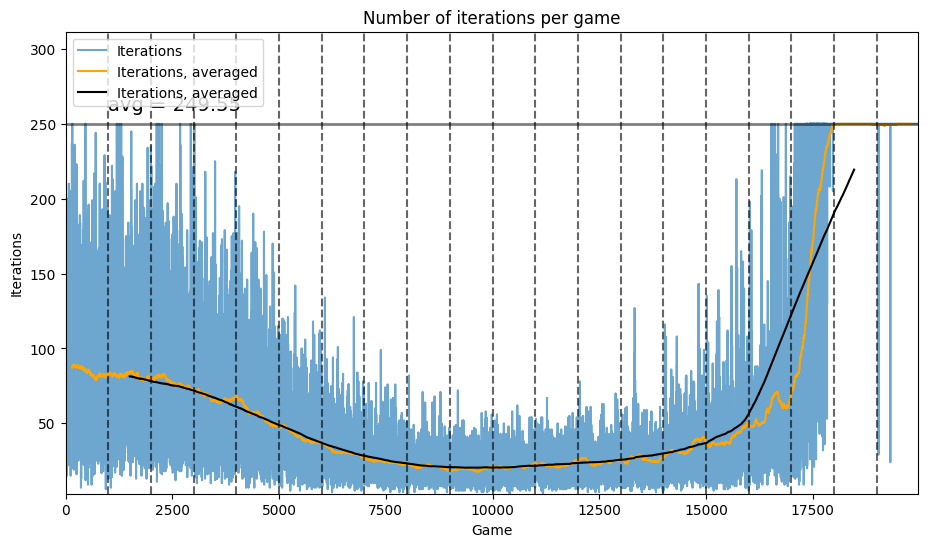

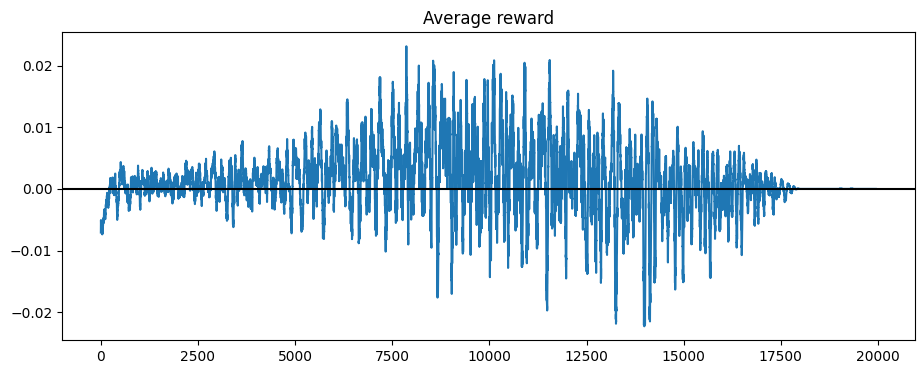

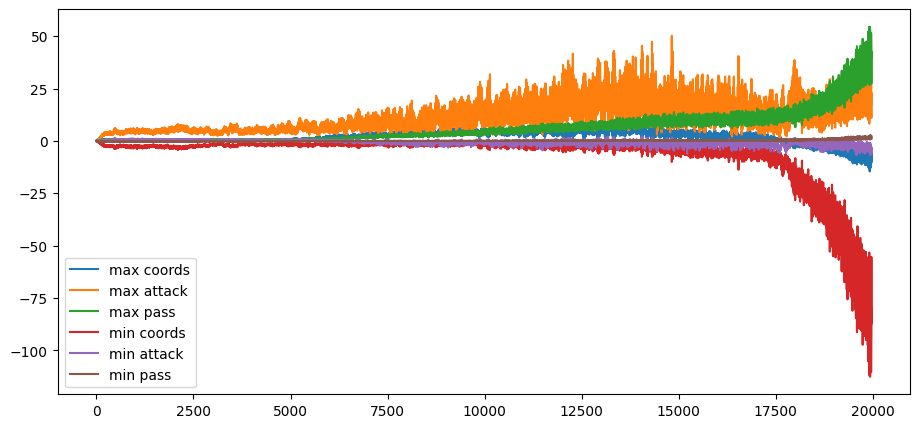

Training:  40%|###9      | 19971/50000 [2:09:11<4:05:18,  2.04it/s, memory_position=186]

In [243]:
last_update = time.time()
marker_60 = None

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        gen.reset()
        game = gen.generate_balanced_game(targetCR=1)
        # game = generate_balanced_game(board_size, game_config)

        output = agent.predict(game.observe_board())
        mags_max.append(np.max(output, axis=(1, 2)))
        mags_min.append(np.min(output, axis=(1, 2)))
        if marker_60 is None and mags_max[-1][1] >= 59:
            marker_60 = i

        iter_count, miter_count = train_loop(agent, game, reward_policy, iter_limit=game_iter_limit, raise_on_limit=False)
        iters.append(iter_count)
        rewards.append(np.sum(agent.reward_memory[max(0, agent.memory_position - miter_count):agent.memory_position]))
        for _ in range(learn_iterations): agent.random_learn()

        pbar.set_postfix({'memory_position': agent.memory_position})

        ctime = time.time()
        if ctime - last_update > 20:
            clear_output(wait=True)
            plot_training_history(iters, checkpoints=checkpoints, min_ymax=20, average_last=average_result_over)
            plt.figure(figsize=(11, 4))
            window = np.ones(50) / 50
            plt.plot((np.convolve(rewards, window, mode='same') / np.convolve(iters, window, mode='same'))[:-25])
            plt.axhline(0, c='k')
            plt.title('Average reward')
            plt.show()
            mmax = np.array(mags_max)
            mmin = np.array(mags_min)

            plt.figure(figsize=(11, 5))
            plt.plot(mmax, label=['max coords', 'max attack', 'max pass'])
            plt.plot(mmin, label=['min coords', 'min attack', 'min pass'])
            plt.legend()
            plt.show()
            if hasattr(pbar, 'container'): display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_interval:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-average_result_over:]) # recent performance
            agent.save_agent(os.path.join(gen_path, f'checkpoints/agent-{avg:0.1f}i-{iter_i / 1000:0.1f}k'))

1145/50000 

In [ ]:
#print(np.array(mags_max)[:,1])
marker_60

In [ ]:
np.sum(agent.future_reward_memory[agent.actions_memory < 128])

293.7254

In [ ]:
np.sum(agent.future_reward_memory[agent.actions_memory >= 128])

104.15608

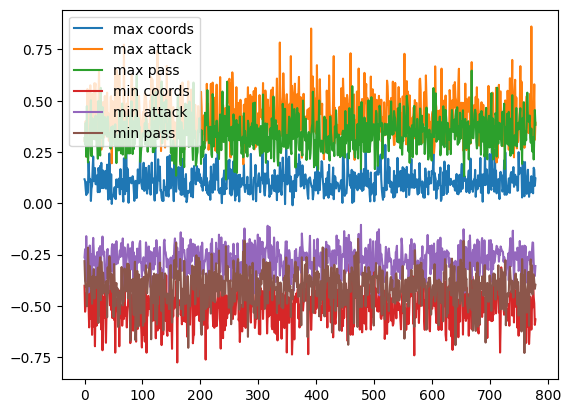

In [ ]:
mmax = np.array(mags_max)
mmin = np.array(mags_min)

plt.plot(mmax, label=['max coords', 'max attack', 'max pass'])
plt.plot(mmin, label=['min coords', 'min attack', 'min pass'])
plt.legend()
plt.show()

In [ ]:
seed_everything(3)
gen.reset()
#game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
game, colormap = decorate_game(gen.generate_balanced_game(targetCR=1))

agents_play_loop([agent, agent], game, colormap, reset_epsilon=False, delay=2)

Iteration: 29
Unit finishes turn
Units alive: 3
Players: 2:
	Player #0 (1 units): `Ally Ape (20 HP)`  
	Player #1 (2 units): `Enemy Zombie 2 (23 HP)`, `Enemy Squire 2 (11 HP)`  
	
    0 1 2 3 4 5 6 7
 0   ██          ██ 0 
 1                  1 
 2                  2 
 3                  3 
 4                  4 
 5                  5 
 6 ██               6 
 7                  7 
    0 1 2 3 4 5 6 7

Next move is by player #1: `Enemy Zombie 2`

Game interrupted after 30 iterations


# Visualization

In [ ]:
gen.reset()
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
print_game(game, colormap)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0                  0 
 1                  1 
 2                  2 
 3     ██           3 
 4                  4 
 5     ██           5 
 6                  6 
 7   ██  ██         7 
    0 1 2 3 4 5 6 7

Next move is by player #1: `Enemy archer`


C:\Users\Admin\AppData\Local\Temp\ipykernel_10108\2948519050.py:2: DeprecationWarning: generate_balanced_game is now performed through `fieldGenerator` class
  game, colormap = decorate_game(generate_balanced_game(board_size, game_config))


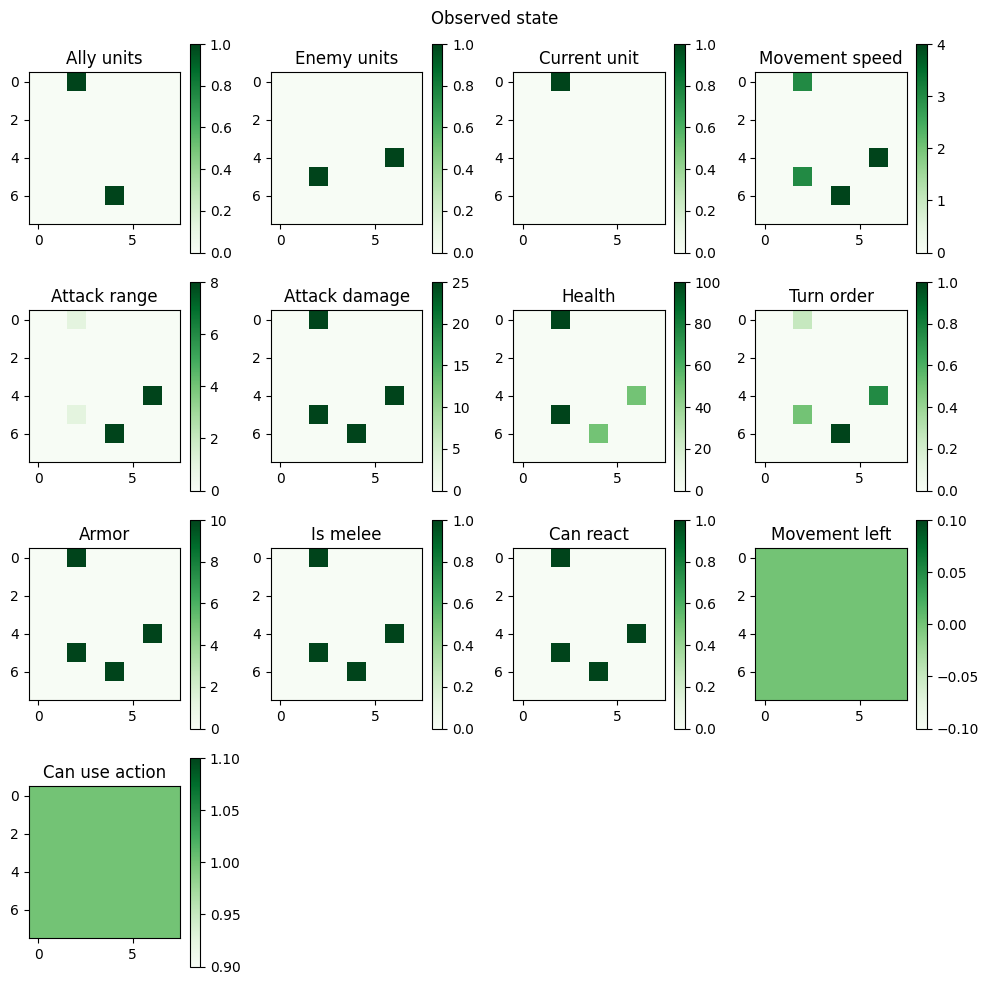

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

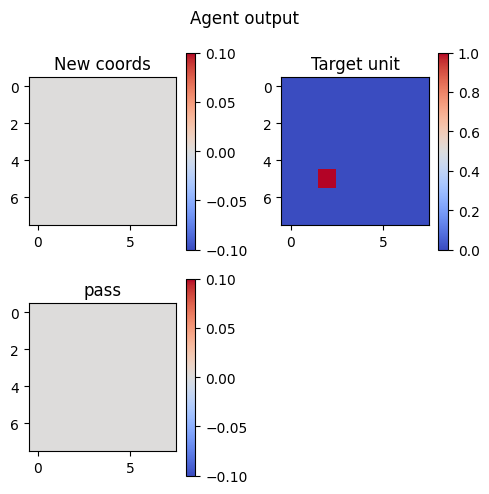

(1, 5, 2)


In [ ]:
state = game.observe_board()
output = agent.predict_probabilities(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit', 'pass'],
    separate_cbars=True
)

print(agent.choose_single_action(state))

In [ ]:
seed_everything(0)
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
print_game(game, colormap)

In [ ]:
from src.agent.agent_utils import agent_take_turn
agent_take_turn(game, agent, None, True)
#print_game(game, colormap)

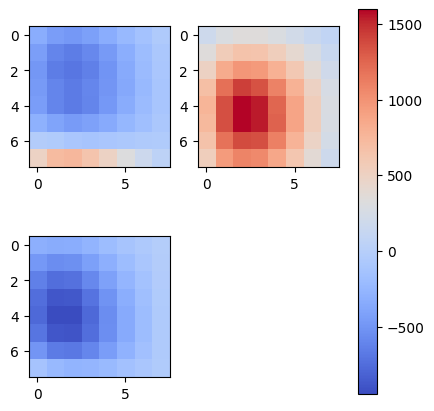

In [ ]:
state = game.observe_board()
plot_featuremaps(agent.predict(state))

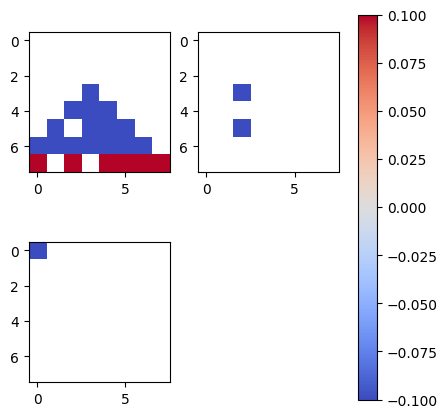

In [ ]:
state = game.observe_board()
mask = agent.legal_moves_masker(state, 3)
output = agent.predict(state)
output[(1 - mask).astype(bool)] = float('NaN')

plot_featuremaps(output)

In [ ]:
probabilities = output.detach().cpu().numpy().reshape(self.out_channels, *self.board_shape)
if filter: probabilities = self.legal_moves_filter(state, probabilities)
probabilities -= np.min(probabilities)
return probabilities / np.sum(probabilities)

In [ ]:
output = agent.predict(state)
output = torch.flatten(torch.tensor(output, device=agent.device, dtype=torch.float32))

porbs = torch.nn.functional.softmax(output, dim=0).detach().cpu().numpy()
porbs

array([1.41203117e-28, 1.89420984e-30, 1.56611803e-32, 1.27812947e-34,
       2.63934929e-36, 1.99618711e-37, 2.68705370e-38, 8.54533243e-39,
       4.05735605e-31, 2.25776642e-32, 5.21158864e-34, 5.56096574e-36,
       7.08273865e-38, 3.06420674e-39, 3.03163916e-40, 8.54385687e-41,
       1.12123215e-33, 1.16341282e-34, 5.42783727e-36, 1.00490285e-37,
       1.44297448e-39, 3.15166038e-41, 3.42897734e-42, 9.44475165e-43,
       9.03005663e-36, 8.57407492e-37, 4.86566252e-38, 9.01296955e-40,
       1.56483000e-41, 5.35296013e-43, 5.32493416e-44, 1.82168800e-44,
       2.69623305e-38, 2.34221433e-39, 1.32716978e-40, 3.88580064e-42,
       1.20511668e-43, 9.80908925e-45, 1.40129846e-45, 1.40129846e-45,
       1.24875311e-40, 1.48439546e-41, 1.34524653e-42, 7.14662217e-44,
       5.60519386e-45, 1.40129846e-45, 0.00000000e+00, 0.00000000e+00,
       1.36486470e-42, 2.49431127e-43, 4.06376555e-44, 4.20389539e-45,
       1.40129846e-45, 0.00000000e+00, 0.00000000e+00, 1.40129846e-45,
      